# 评估结果

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score
from scipy.spatial.distance import directed_hausdorff
from natsort import natsorted
from tqdm import tqdm
from celluloid import Camera  

# 定义文件夹路径
imagesTs_folder = './imagesTs'  
pred_folder = './imagesTs_pred_3D_fullres'  

# 获取文件列表并排序
imagesTs_files = natsorted([f for f in os.listdir(imagesTs_folder) if f.endswith('.nii.gz')])
pred_files = natsorted([f for f in os.listdir(pred_folder) if f.endswith('.nii.gz')])

# 初始化评估指标
dice_scores = []
jaccard_scores = []
hausdorff_distances = []

# 遍历每个图像和预测结果进行评估
for img_file, pred_file in tqdm(zip(imagesTs_files, pred_files), total=len(imagesTs_files)):
    # 加载原始图像和分割结果
    img_path = os.path.join(imagesTs_folder, img_file)
    pred_path = os.path.join(pred_folder, pred_file)
    
    img_nifti = nib.load(img_path)
    pred_nifti = nib.load(pred_path)

    img_data = img_nifti.get_fdata()
    pred_data = pred_nifti.get_fdata()

    # 二值化原始图像和预测结果
    img_binary = (img_data > 0).astype(np.uint8)
    pred_binary = (pred_data > 0.5).astype(np.uint8)

    # 计算Dice系数和Jaccard系数
    dice = f1_score(img_binary.flatten(), pred_binary.flatten())
    jaccard = jaccard_score(img_binary.flatten(), pred_binary.flatten())

    # 转换为二维点集格式（用于计算Hausdorff距离）
    img_coords = np.column_stack(np.where(img_binary > 0))
    pred_coords = np.column_stack(np.where(pred_binary > 0))

    # 如果有任何一个分割结果是空的，跳过Hausdorff距离计算
    if img_coords.size == 0 or pred_coords.size == 0:
        hausdorff = np.nan
    else:
        hausdorff = max(
            directed_hausdorff(img_coords, pred_coords)[0],
            directed_hausdorff(pred_coords, img_coords)[0]
        )

    # 存储评估结果
    dice_scores.append(dice)
    jaccard_scores.append(jaccard)
    hausdorff_distances.append(hausdorff)

# 打印评估结果的平均值
print(f"Average Dice Score: {np.mean(dice_scores):.4f}")
print(f"Average Jaccard Score: {np.mean(jaccard_scores):.4f}")
print(f"Average Hausdorff Distance: {np.nanmean(hausdorff_distances):.4f}")

100%|██████████| 27/27 [27:05<00:00, 60.19s/it]  

Average Dice Score: 0.0160
Average Jaccard Score: 0.0081
Average Hausdorff Distance: 102.1825


# 可视化

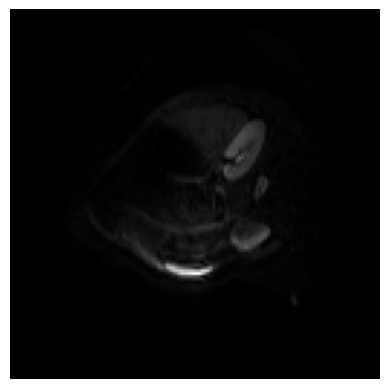

In [4]:
# 图像可视化展示
fig = plt.figure()
camera = Camera(fig)

# 选择一个图像和对应的分割结果进行可视化
sample_img_file = imagesTs_files[0]
sample_pred_file = pred_files[0]

sample_img_path = os.path.join(imagesTs_folder, sample_img_file)
sample_pred_path = os.path.join(pred_folder, sample_pred_file)

sample_img_nifti = nib.load(sample_img_path)
sample_pred_nifti = nib.load(sample_pred_path)

sample_img_data = sample_img_nifti.get_fdata()
sample_pred_data = (sample_pred_nifti.get_fdata() > 0.5).astype(np.uint8)

# 遍历每一层进行可视化
for i in range(sample_img_data.shape[2]):
    img_slice = sample_img_data[:, :, i]
    pred_slice = sample_pred_data[:, :, i]

    # 将分割结果和原图叠加
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(np.ma.masked_where(pred_slice == 0, pred_slice), alpha=0.6, cmap='spring')

    plt.axis('off')
    camera.snap()

# 生成动画
animation = camera.animate()
plt.show()